In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob

from dask.distributed import Client

In [2]:
client = Client(n_workers=14)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35639 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35639/status,
Dashboard: /proxy/35639/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44389,Workers: 14
Dashboard: /proxy/35639/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:45639,Total threads: 1
Dashboard: /proxy/38771/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38245,


In [3]:
base = '/g/data/ik11/outputs/'
# IAF runs:
runs = {'JRA55 RYF 1-deg':{'base':base+'access-om2/1deg_jra55v14_ryf','color':'C0','chunks':{'grid_yu_ocean':100}},
        'ERA5 RYF 1-deg':{'base':base+'access-om2/1deg_era5_ryf','color':'C1','chunks':{'grid_yu_ocean':100}},
        'JRA55 RYF 025-deg':{'base':base+'access-om2-025/025deg_jra55_ryf_era5comparison','color':'C2','chunks':{'grid_yu_ocean':108}},
        'ERA5 RYF 025-deg':{'base':base+'access-om2-025/025deg_era5_ryf','color':'C3','chunks':{'grid_yu_ocean':108}}
       }

## Date range for each experiment

In [4]:
for ekey in runs.keys():
    ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-scalar*.nc')))
    start = ds.time.isel(time=0)
    end = ds.time.isel(time=-1)
    print(ekey + ' ' + str(start.values)[:10] + ' to ' + str(end.values)[:10])

JRA55 RYF 1-deg 1900-01-02 to 2000-01-01
ERA5 RYF 1-deg 1900-01-02 to 2000-01-01
JRA55 RYF 025-deg 1900-01-02 to 1920-01-01
ERA5 RYF 025-deg 1900-01-02 to 1921-01-01


## Scalar diagnostics

In [5]:
def plot_timeseries(variable,keys=runs.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-scalar*.nc')))
        var = ds[variable]#.resample(time='1M').mean()
        var.plot(label=ekey,color=runs[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.legend()
    return

Text(0.5, 1.0, 'Total Kinetic Energy')

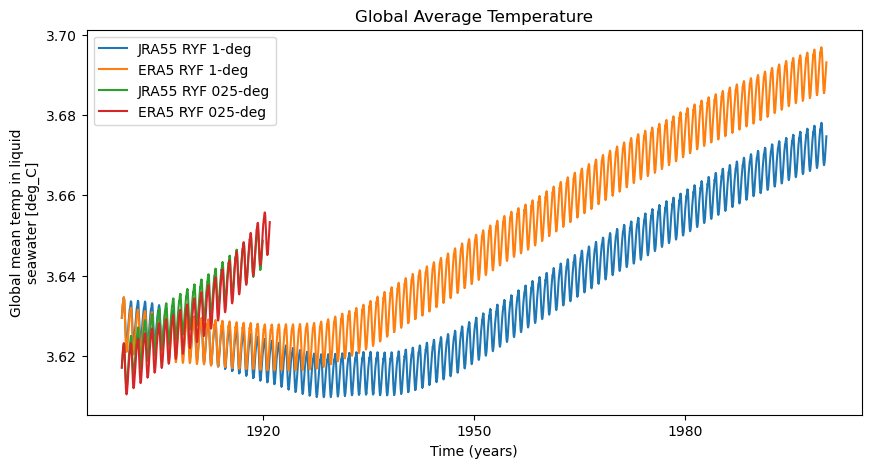

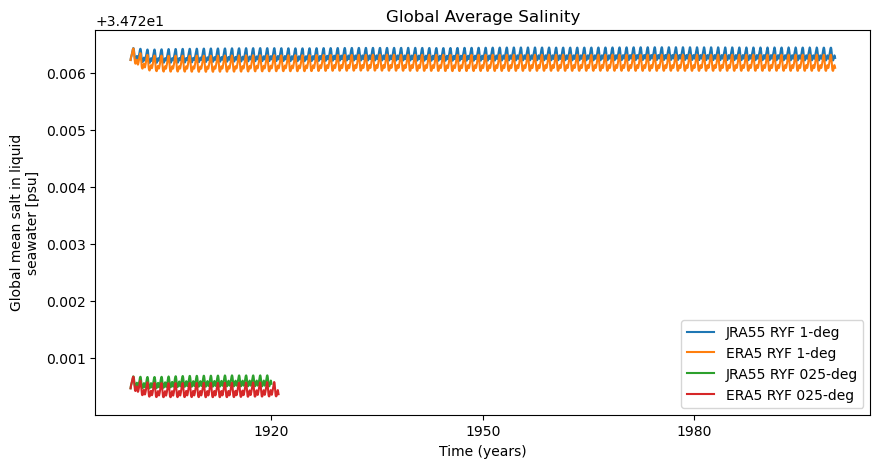

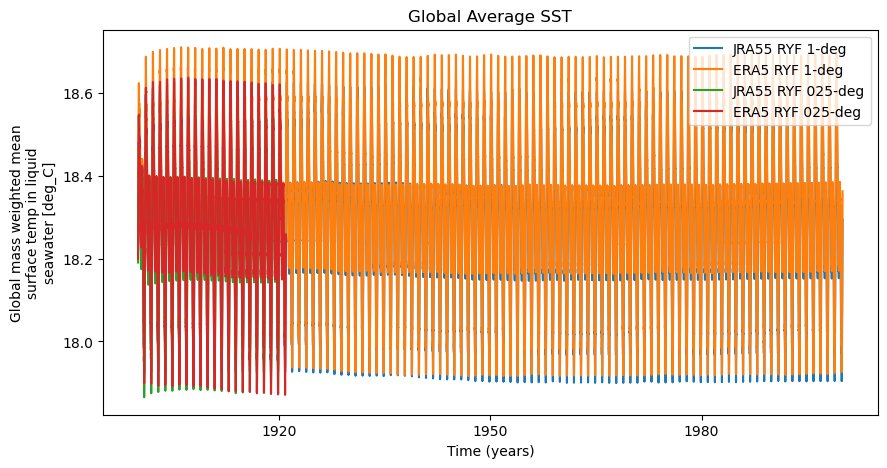

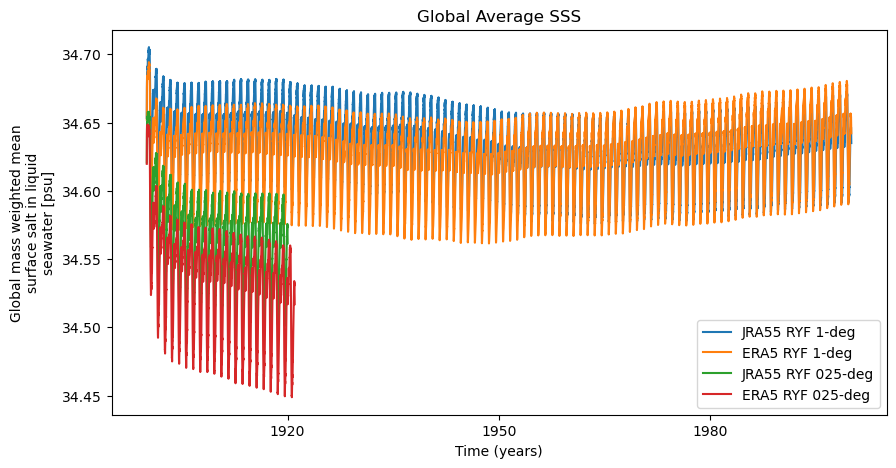

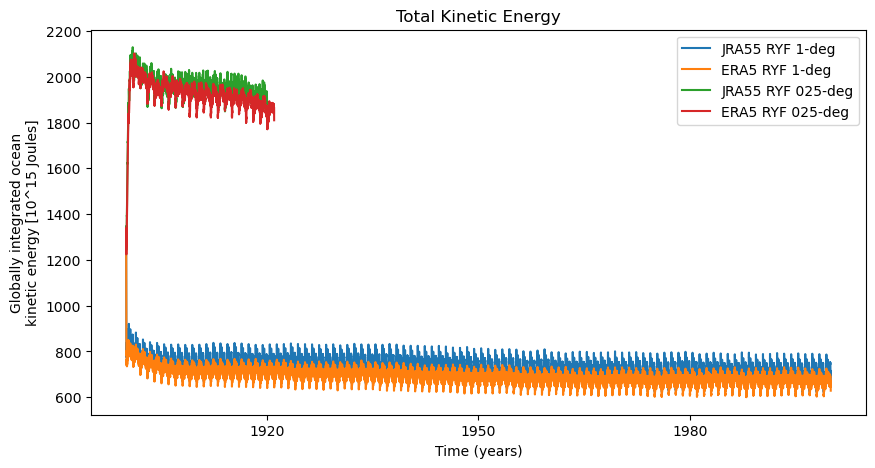

In [6]:
plot_timeseries('temp_global_ave')
plt.title('Global Average Temperature')
plot_timeseries('salt_global_ave')
plt.title('Global Average Salinity')
plot_timeseries('temp_surface_ave')
plt.title('Global Average SST')
plot_timeseries('salt_surface_ave')
plt.title('Global Average SSS')
plot_timeseries('ke_tot')
plt.title('Total Kinetic Energy')

## Circulation Diagnostics

### Drake Passage Transport

JRA55 RYF 1-deg
ERA5 RYF 1-deg
JRA55 RYF 025-deg
ERA5 RYF 025-deg
CPU times: user 11.2 s, sys: 1.81 s, total: 13 s
Wall time: 21.7 s


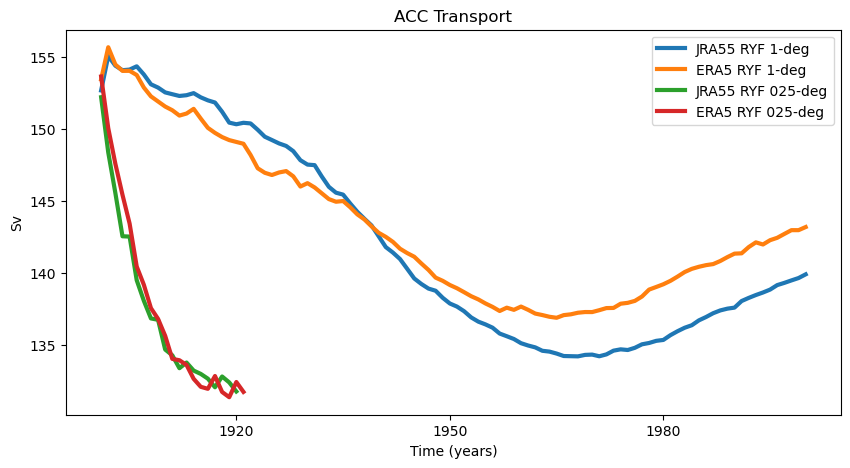

In [7]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in runs.keys():
    print(ekey)
    ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-2d-tx_trans_int_z-1-monthly-mean*.nc')))
    var = ds[variable]
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
    DP.resample(time='Y').mean().plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.legend()

### AMOC Overturning in density space @ 26°N

Data not found for JRA55 RYF 1-deg
Data not found for ERA5 RYF 1-deg
Data not found for JRA55 RYF 025-deg


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data not found for ERA5 RYF 025-deg
CPU times: user 164 ms, sys: 97.6 ms, total: 262 ms
Wall time: 520 ms


Text(0.5, 1.0, 'AMOC (rho) at 26N')

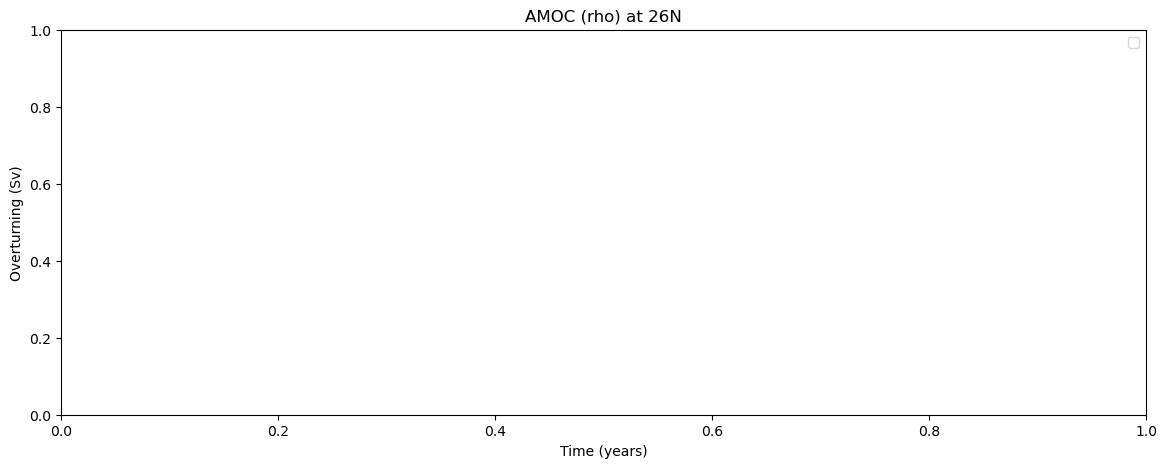

In [10]:
%%time
latitude=26.
plt.figure(figsize=(14,5))
for ekey in runs.keys():
    try:
        ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
        ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

        var_out = xr.zeros_like(ds1.time.resample(time='Y').mean()).astype('float')
        for i in range(len(var_out.time)-1):
            if ((i % 20) == 0):
                print('Doing ' + ekey + ' year %03d of %03d' % (i,len(var_out.time)))
            ds1_year = ds1.isel(time=slice(i*12,(i+1)*12))
            ds2_year = ds2.isel(time=slice(i*12,(i+1)*12))
            psi_amoc = ds1_year['ty_trans_rho'].sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
            psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
            psi_amoc_gm = ds2_year['ty_trans_rho_gm'].sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
            psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
            psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
            var_out[i] = psi_amoc_sum.mean('time').values
        var_out.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
    except:
        print('Data not found for ' + ekey)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 26N')

### AABW overturning circulation @ 55°S

Data not found for JRA55 RYF 1-deg
Data not found for ERA5 RYF 1-deg
Data not found for JRA55 RYF 025-deg
Data not found for ERA5 RYF 025-deg


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 160 ms, sys: 83.4 ms, total: 243 ms
Wall time: 315 ms


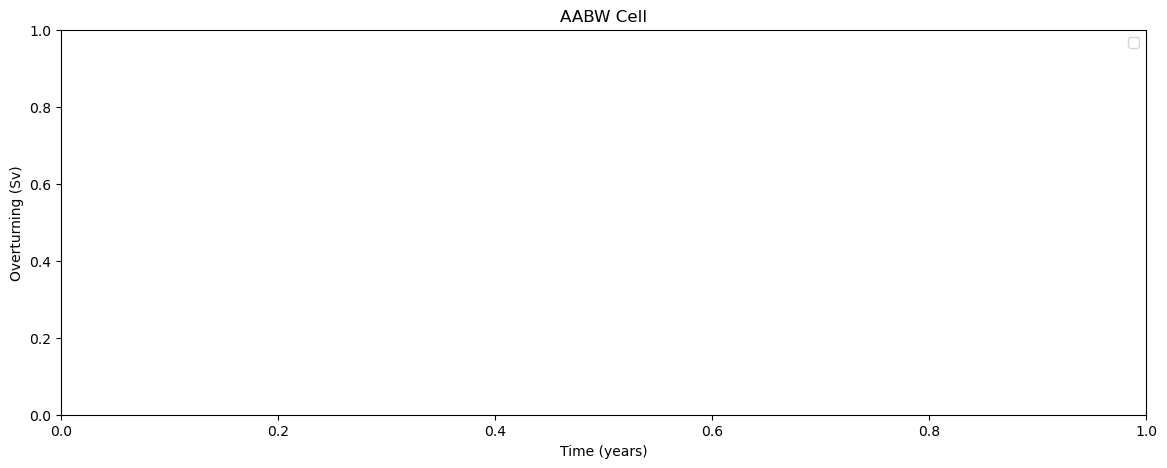

In [11]:
%%time
latitude=-55
plt.figure(figsize=(14,5))
for ekey in runs.keys():
    try:
        ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
        ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

        var_out = xr.zeros_like(ds1.time.resample(time='Y').mean()).astype('float')
        for i in range(len(var_out.time)-1):
            if ((i % 20) == 0):
                print('Doing ' + ekey + ' year %03d of %03d' % (i,len(var_out.time)))
            ds1_year = ds1.isel(time=slice(i*12,(i+1)*12))
            ds2_year = ds2.isel(time=slice(i*12,(i+1)*12))
            psi_aabw = ds1_year['ty_trans_rho'].sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
            psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
            psi_aabw_gm = ds2_year['ty_trans_rho_gm'].sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
            psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
            psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
            var_out[i] = psi_aabw_sum.mean('time').values
        var_out.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
    except:
        print('Data not found for ' + ekey)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

### Ice Area (in both hemispheres)

JRA55 RYF 1-deg
ERA5 RYF 1-deg
JRA55 RYF 025-deg
ERA5 RYF 025-deg


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Southern Ocean')

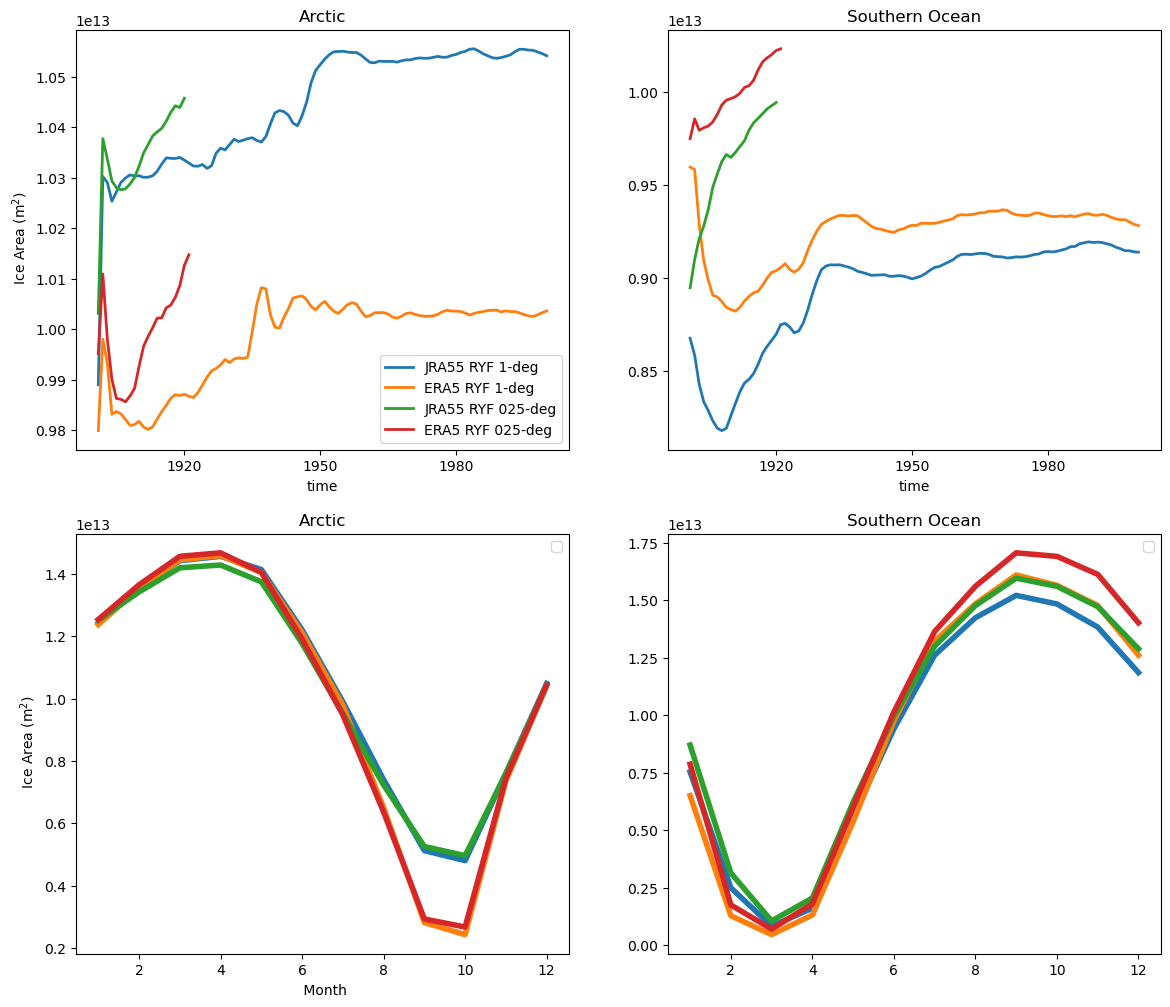

In [13]:
variable='aice_m'
fig,axes = plt.subplots(2,2,figsize=(14,12))
for ekey in runs.keys():
    print(ekey)
    
    lt = sorted(glob.glob(runs[ekey]['base'] + '/output***/ice/OUTPUT/iceh.*.nc'))
    lt = [item for item in lt if 'daily' not in item]
    ds = xr.open_mfdataset(lt, concat_dim="time", combine="nested",
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True)
    var = ds['aice_m']
    area_t = xr.open_dataset(runs[ekey]['base'] + '/output000/ocean/ocean-2d-area_t.nc')['area_t']
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    
    #NH_area.plot(ax=axes[0],label=ekey,color=runs[ekey]['color'])
    #SH_area.plot(ax=axes[1],label=ekey,color=runs[ekey]['color'])
    NH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0][0],color=runs[ekey]['color'],linewidth=2.,label=ekey)
    SH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0][1],color=runs[ekey]['color'],linewidth=2.)

    NH_all = NH_area.isel(time=slice(-10*12,None)).groupby('time.month').mean()
    SH_all = SH_area.isel(time=slice(-10*12,None)).groupby('time.month').mean()
    axes[1][0].plot(np.arange(1,13),NH_all.values,color=runs[ekey]['color'],linewidth=4.)
    axes[1][1].plot(np.arange(1,13),SH_all.values,color=runs[ekey]['color'],linewidth=4.)
        
axes[0][0].set_ylabel(' Ice Area (m$^2$)')
axes[0][0].legend()
axes[0][0].set_title('Arctic')
axes[0][1].set_title('Southern Ocean')
axes[1][0].set_ylabel(' Ice Area (m$^2$)')
axes[1][0].set_xlabel(' Month')
axes[1][0].legend()
axes[1][1].legend()
axes[1][0].set_title('Arctic')
axes[1][1].set_title('Southern Ocean')